# Day 15: Decisions Under Uncertainty

---

- aleatory vs epistemic uncertainty
- modeling under uncertainty
- decision strategies


In [1]:
import pandas as pd 
import grama as gr 
import numpy as np

from scipy.stats import lognorm
from plotnine import *

DF = gr.Intention()


# Aleatory vs Epistemic Uncertainty

---

- *Aleatory* uncertainty: Uncertainty due to inherent randomness
  - This comes from the latin *alea*, which is the name of a game played with dice
- *Epistemic* uncertainty: Uncertainty due to a lack of knowledge
  - This comes from the greek *episteme*, which means knowledge

Most *real* scenarios involving uncertainty have both aleatory and epistemic components.

Statistics is a toolkit for working quantitatively with mixed aleatory-epistemic uncertainty.

Note that whether a scenario has aleatory, epistemic, or both kinds of uncertainty depends on the features of use case *and* our intended action.


## Illustrative example: Strength of a material

Suppose we knew the distribution of strength values **exactly** for a specific material. Let's call it *unobtainium*.

### Case 1: Mean of a known distribution

Suppose we analytically compute the mean $\mu$ of a known distribution.


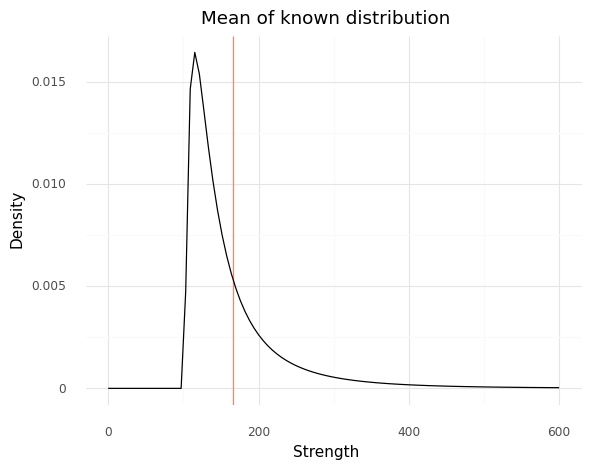

<ggplot: (8730415052451)>

In [2]:
## Define the strength distribution
param = dict(loc=100, s=1, scale=40)
marg_strength = gr.MarginalNamed(d_name="lognorm", d_param=param)
mu_exact = float(lognorm(**param).stats("m"))

## Visualize
X_strength = np.linspace(0, 600, num=100)
L_strength = list(map(marg_strength.l, X_strength))
df_pdf = gr.df_make(x=X_strength, l=L_strength)

(
    df_pdf
    >> ggplot(aes("x", "l"))
    + geom_vline(xintercept=mu_exact, color="salmon")
    + geom_line()
    
    + theme_minimal()
    + labs(
        x="Strength",
        y="Density",
        title="Mean of known distribution",
    )
)


1. Is there uncertainty in $\mu$?
2. If "yes" to (1), what kind of uncertainty does $\mu$ exhibit? Aleatory, epistemic, both, or none?

<br>
<br>
<br>

There is **no** uncertainty in $\mu$; it is known exactly!


### Case 2: Sampling a known distribution

We will sample $X \sim \rho$ from the following *known* distribution $\rho$.

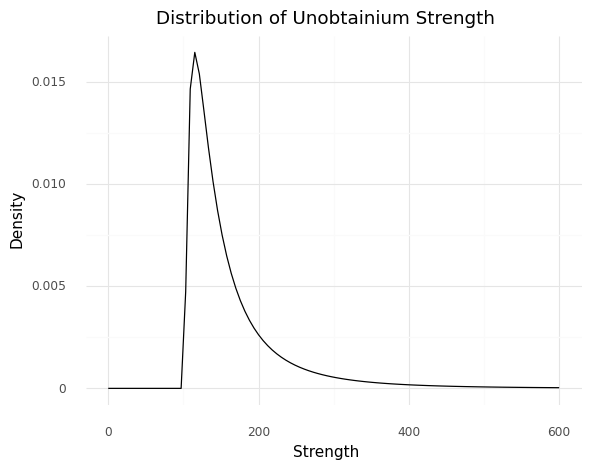

<ggplot: (8730415068907)>

In [3]:
## Define the strength distribution
marg_strength = gr.MarginalNamed(d_name="lognorm", d_param=dict(loc=100, s=1, scale=40))

## Visualize
X_strength = np.linspace(0, 600, num=100)
L_strength = list(map(marg_strength.l, X_strength))
df_pdf = gr.df_make(x=X_strength, l=L_strength)

(
    df_pdf
    >> ggplot(aes("x", "l"))
    + geom_line()
    
    + theme_minimal()
    + labs(
        x="Strength",
        y="Density",
        title="Distribution of Unobtainium Strength",
    )
)


1. Is there uncertainty in $X$?
2. If "yes" to (1), what kind of uncertainty does $X$ exhibit? Aleatory, epistemic, both, or none?

<br>
<br>
<br>

Sampling $X$ has aleatory uncertainty *only*; by construction we're assuming the distribution is known, so there is no lack of knowledge. We know everything that can possibly be known about this case.


### Case 3: Confidence interval on the mean

We have a sample $\{X_i\}_{i=1}^n$ from the distribution $X_i \stackrel{iid}{\sim} \rho$, and we use this sample to compute a confidence interval for the mean. We will **not** allow ourselves access to the true distribution when assessing the mean; we will use our sample only.


Design runtime estimates unavailable; model has no timing data.


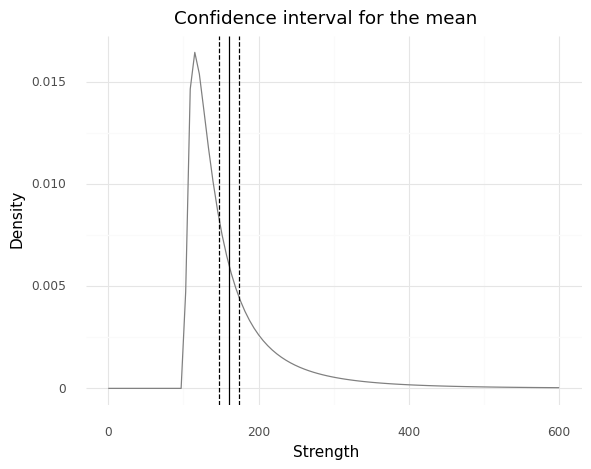

<ggplot: (8730415074446)>

In [4]:
df_sample = (
    gr.Model()
    >> gr.cp_marginals(x=marg_strength)
    >> gr.cp_copula_independence()
    >> gr.ev_monte_carlo(n=100, df_det="nom", seed=101, skip=True)
)

(
    df_sample
    >> gr.tf_summarize(
        mu_hat=gr.mean(DF.x),
        se_hat=gr.sd(DF.x) / gr.sqrt(gr.n(DF.x)),
    )
    >> gr.tf_mutate(
        mu_lo=DF.mu_hat - 1.96 * DF.se_hat,
        mu_hi=DF.mu_hat + 1.96 * DF.se_hat,
    )
    
    >> ggplot()
    + geom_line(data=df_pdf, mapping=aes("x", "l"), color="grey")
    + geom_vline(
        aes(xintercept="mu_lo"),
        linetype="dashed",
    )
    + geom_vline(
        aes(xintercept="mu_hi"),
        linetype="dashed",
    )
    + geom_vline(aes(xintercept="mu_hat"))
    
    + theme_minimal()
    + labs(
        x="Strength",
        y="Density",
        title="Confidence interval for the mean",
    )
)

1. Is there uncertainty in our estimated mean $\hat{\mu}$?
2. If "yes" to (1), what kind of uncertainty does $\hat{\mu}$ exhibit? Aleatory, epistemic, both, or none?

<br>
<br>
<br>

The estimated mean exhibits epistemic uncertainty, but not aleatory uncertainty. Here the sample is fixed, so there is no "additional randomness" that can show up; inherent randomness gave rise to uncertainty in the first place, but all of our uncertainty at this point is due to a lack of knowledge.


### Case 4: Using a fitted model for design

We have a sample $\{X_i\}_{i=1}^n$ from the distribution $X_i \stackrel{iid}{\sim} \rho$, and we use this sample to fit a model $\hat{\rho}$ that we will use for sizing a structural component.


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


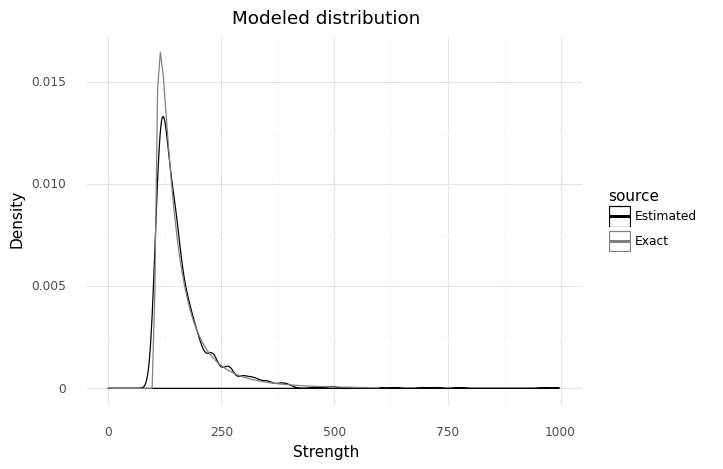

<ggplot: (8730415074329)>

In [5]:
df_sample = (
    gr.Model()
    >> gr.cp_marginals(x=marg_strength)
    >> gr.cp_copula_independence()
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=101, skip=True)
)

md_fit = (
    gr.Model()
    >> gr.cp_marginals(
        x=gr.marg_named(df_sample.x, "lognorm")
    )
    >> gr.cp_copula_independence()
)

(
    md_fit
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=103, skip=True)
    >> gr.tf_mutate(source="Estimated")
    
    >> ggplot(aes("x", color="source"))
    + geom_density()
    + geom_line(
        data=df_pdf
        >> gr.tf_mutate(source="Exact"),
        mapping=aes(y="l"),
    )
    
    + scale_color_manual(values=dict(Estimated="black", Exact="grey"))
    + theme_minimal()
    + labs(
        x="Strength",
        y="Density",
        title="Modeled distribution",
    )
)


1. Is there uncertainty in the performance of a structure designed using the `Estimated` model?
2. If "yes" to (1), what kind of uncertainty does the resulting structure exhibit? Aleatory, epistemic, both, or none?

<br>
<br>
<br>

The resulting structure will have both epistemic and aleatory uncertainty. We've already seen that the underlying material property $X$ is inherently random (aleatory uncertainty). However, the model used to design the structure was based on limited information, which means there is epistemic uncertainty "baked into" the design.


### Aleatory vs Epistemic, closing notes

- I write about aleatory vs epistemic uncertainty in Section 2.2.1 of my PhD thesis.
- In the scenarios above, epistemic uncertainty *arose* from sources of epistemic uncertainty. This happens frequently in practice, but it's not the only way epistemic uncertainty can happen.
  - For instance, I write about *model form errors* in Section 2.2.2 of my PhD thesis.
- Note that whether a given source of uncertainty is aleatory or epistemic depends on the modeling choices and intended use of the model; Der Kiureghian and Ditlevsen write about this in their (2009) paper.


# Modeling

---

Here's a suggested procedure for physical modeling:

1. Determine use case
2. Select performance measures
3. Identify constraints
4. Determine variables and parameters
5. Identify and model uncertainties

We'll illustrate this through the design of a cantilever beam


### 1. Determine use case

We'll consider using a cantilever beam in two different use-cases:

> Use-case A: Load-bearing member in a building

> Use-case B: Standoff on an optics table


### 2. Select performance measures

| Measure | Symbol | Objective |
|---|---|---|
| Tip deflection | $\delta$ | Minimize |
| Cost | $C$ | Minimize |



### 3. Identify constraints

| Description | Constraint |
|---|---|
| Maximum stress | `sigma < sigma_max` |
| Space constraints | `w <= w_max, t <= t_max` |


### 4. Determine variables and parameters

The choice of parameter / variable strongly depends on the problem details. Here's one example for how we might categorize quantities:

| Quantity | Symbol | Category |
|---|---|---|
| GEO: Overall geometry |  |  |
| GEO: width | `w` | variable |
| GEO: thickness | `t` | variable |
| GEO: length | `l` | parameter |
| | |
| LOAD: Load distribution |  |  |
| LOAD: Vertical tip load | `v` | parameter |
| LOAD: Horizontal tip load | `h` | parameter |
| | |
| MAT: Material properties |  |  |
| MAT: elasticity | `e` | parameter |
| MAT: yield strength | `y` | parameter |



### 5. Identify and model uncertainties

**Example**: Geometric tolerances

If our manufacturing tolerances are relatively tight and variability is unlikely to matter, we might be justified in treating $w, t$ as chosen, deterministic values.

If manufacturing tolerances are not so tight or if we're working on a high-precision application, we may need to account for tolerances on the geometry. In this case, we may instead choose to model the *realized dimensions* as perturbed versions of their selected dimensions:

$$W = w + \delta w,\text{ where }\delta w \sim \rho_w$$
$$T = t + \delta t,\text{ where }\delta t \sim \rho_t$$

Often, we'll model these perturbations as having zero mean $\mathbb{E}[\delta w] = \mathbb{E}[\delta t] = 0$. In this case, we're essentially setting the means of the distributions for $W, T$ and modeling variation with random variables.

Visually, we can depict this as some kind of distribution of design values around a nominal point:


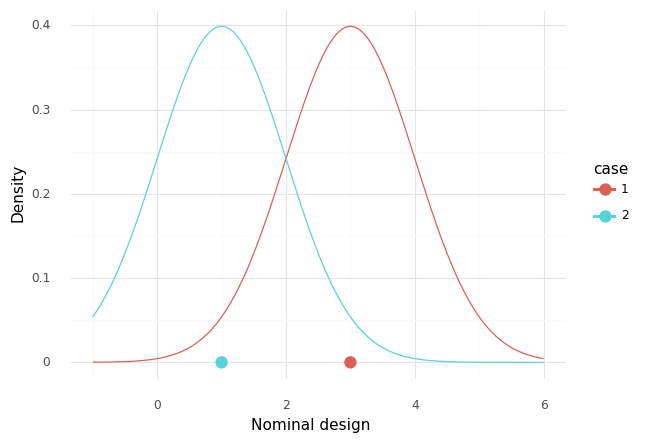

<ggplot: (8730410192659)>

In [35]:
(
    gr.df_make(x=np.linspace(-1, +6, num=500))
    >> gr.tf_mutate(
        l_1=gr.exp(-0.5 * (DF.x - 3)**2) / np.sqrt(2 * np.pi),
        l_2=gr.exp(-0.5 * ((DF.x - 1))**2) / np.sqrt(2 * np.pi),
    )
    >> gr.tf_gather("key", "l", ["l_1", "l_2"])
    >> gr.tf_mutate(case=gr.str_extract(DF.key, "\\d"))
    
    >> ggplot(aes("x", "l", color="case"))
    + geom_line()
    + geom_point(
        data=gr.df_make(
            x=[1, 3],
            l=[0, 0],
            case=["2", "1"]
        ),
        size=4,
    )
    
    + theme_minimal()
    + labs(x="Nominal design", y="Density")
)

This kind of modeling is important to avoid selecting non-robust designs; for instance, imagine we had the following optimization landscape:


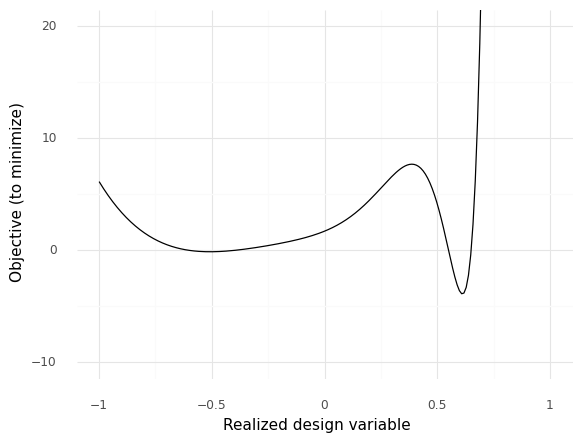

<ggplot: (8730409224692)>

In [38]:
md_poly = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=(df.x + 0.6)
             *(df.x + 0.4)
             *(df.x - 0.65)
             *(df.x - 0.55)
             *10 * (1 + np.exp(8.0 * df.x))
        ),
        var=["x"],
        out=["y"],
    )
    >> gr.cp_bounds(x=(-1, +1))
)

(
    md_poly
    >> gr.ev_df(df=gr.df_make(x=np.linspace(-1, +1, num=200)))
    >> ggplot(aes("x", "y"))
    + geom_line()
    + coord_cartesian(ylim=(-10, +20))
    + theme_minimal()
    + labs(
        x="Realized design variable",
        y="Objective (to minimize)"
    )
)


# Decision Strategies

---


### Formulation

Let $d$ be our set of *deterministic* variables, and $X$ be our random variables. Is it *possible* to solve the following?

$$\min\, f(d, X)$$
$$\text{wrt.}\, d, X$$

<br>
<br>
<br>

This is an *incoherent* way to do design, given our modeling choices. If the $X$ are random, then---by definition---we can't choose their values.

What about the following?

$$\min\, f(d, X)$$
$$\text{wrt.}\, d$$

<br>
<br>
<br>

This is still incoherent; how can we "minimize" an entire random variable $F(d) = f(d, X)$? Do we want to control the worst-case? The mean? Something else? We need to be more specific.

There are two broad categories of optimization-under-uncertainty: robust design and reliable design.


## Robust Design

*Philosphy*: Minimize variation, because we can easily fix an offset.


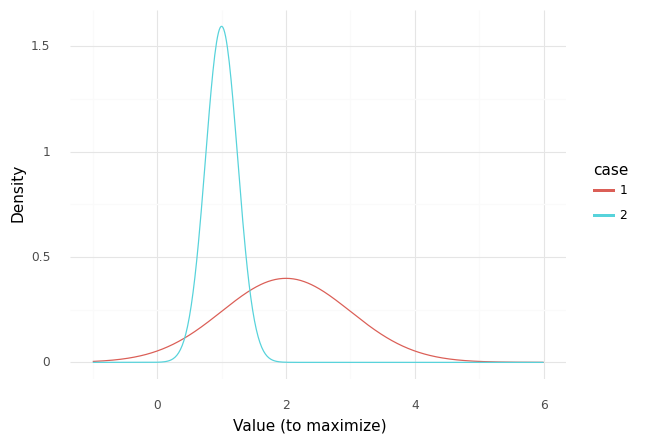

<ggplot: (8730409391981)>

In [22]:
(
    gr.df_make(x=np.linspace(-1, +6, num=500))
    >> gr.tf_mutate(
        l_1=gr.exp(-0.5 * (DF.x - 2)**2) / np.sqrt(2 * np.pi),
        l_2=gr.exp(-0.5 * ((DF.x - 1) / (1/4))**2) / np.sqrt(2 * 1/16 * np.pi),
    )
    >> gr.tf_gather("key", "l", ["l_1", "l_2"])
    >> gr.tf_mutate(case=gr.str_extract(DF.key, "\\d"))
    
    >> ggplot(aes("x", "l", color="case"))
    + geom_line()
    
    + theme_minimal()
    + labs(x="Value (to maximize)", y="Density")
)

A formal robust design optimization program is:

$$\min\, \mathbb{E}[f(d, X)], \mathbb{SD}[f(d, X)]$$
$$\text{wrt.}\, d$$

Note, this is a multi-objective optimization over the mean and standard deviation! (There's a *reason* we learned all this stuff!)


## Reliable Design

*Philosphy*: Constrain the probability of unacceptable failure modes.


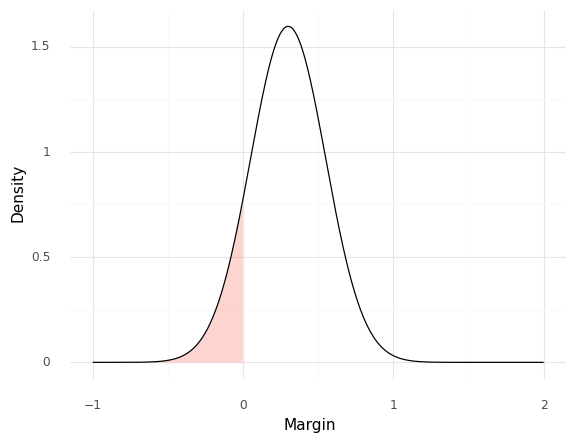

<ggplot: (8730409192391)>

In [30]:
df_tmp = (
    gr.df_make(x=np.linspace(-1, +2, num=500))
    >> gr.tf_mutate(
        l=gr.exp(-0.5 * ((DF.x - 0.3) / (1/4))**2) / np.sqrt(2 * 1/16 * np.pi),
    )
)

(
    df_tmp
    >> ggplot(aes("x", "l"))
    + geom_ribbon(
        data=df_tmp
        >> gr.tf_filter(DF.x <= 0),
        mapping=aes(ymin=0, ymax="l"),
        fill="salmon",
        alpha=1/3,
    )
    + geom_line()
    
    + theme_minimal()
    + labs(x="Margin", y="Density")
)


A formal reliable design optimization program is:

$$\min\, f(d)$$
$$\text{wrt.}\, d$$
$$\text{s.t.}\, \mathbb{P}[g(d, X) \leq 0] \leq \mathcal{F}$$

Note that our objective needs to be deterministic; it could be the mean of some random performance. We could also write the constraint in terms of words:

$$\text{s.t.}\, \mathbb{P}[\text{Catastrophic failure}] \leq \text{Acceptable Failure Rate}$$



## Which philosophy to apply?

For both of the use-cases, which philosophy seems most appropriate: robust or reliable design?

> Use-case A: Load-bearing member in a building

> Use-case B: Standoff on an optics table

<br>
<br>
<br>

> Use-case A: Load-bearing member in a building
> - Structural members of a building have high-consequence failure modes; reliability design makes the most sense to me

> Use-case B: Standoff on an optics table
> - Optics applications require extremely tight tolerances; robust design makes the most sense to me


### Design Under Uncertainty, closing notes

I write about Design Under Uncertainty in Section 2.4 of my PhD thesis.


# References

---

- del Rosario "Precision Margin: First-Principles Margins for Aircraft Design Under Uncertainty" (2020) [PhD thesis](https://purl.stanford.edu/xy114jv5352)
- Der Kiureghian and Ditlevsen, "Aleatory or epistemic? Does it matter?" (2009) [link](https://www.sciencedirect.com/science/article/pii/S0167473008000556?casa_token=wMqEeSrOI-EAAAAA:SvXSdoTgMbaRnYfJ6kSIXOW1Ahs1G7xzIv1BUIvuxuQA-cmRo9E-c15FelBcebHrHNghO7le)
